## Airbnb project

In [2]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import seaborn as sns
import numpy as np
import shapely
from geopy import distance

In [3]:
pd.options.mode.chained_assignment = None

In [322]:
#hood = gpd.read_file('neighbourhoods.geojson')
metro = gpd.read_file('metro.geojson')
df = pd.read_csv('listings.csv')

C:\Users\raffa\anaconda3\lib\site-packages\geopandas\geodataframe.py:35: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)


# Metro dataset

In [5]:
df2 = metro.copy()
for i in range(len(df2)):
    if not '/' in df2['LINHA'][i]:
        df2.drop([i], axis=0, inplace=True)
df2 = df2.reset_index()

In [6]:
for i in range(len(metro)):
    if '/' in  metro['LINHA'][i]:
        metro['LINHA'][i] = metro['LINHA'][i].split('/')[0]

for j in range(len(df2)):
    df2['LINHA'][j] = df2['LINHA'][j].split('/')[1]
    
metro = pd.concat([metro, df2])

In [7]:
metro = pd.concat([metro, df2])
metro = metro.drop(columns = ['index','OBJECTID','COD_SIG','IDTIPO','SITUACAO','GlobalID'])

In [8]:
metro

,NOME,LINHA,geometry
0,Cais do Sodré,Verde,POINT (-9.14609 38.70627)
1,Terreiro do Paço,Azul,POINT (-9.13419 38.70728)
2,Baixa Chiado,Azul,POINT (-9.14015 38.71057)
3,Santa Apolónia,Azul,POINT (-9.12241 38.71404)
4,Rossio,Verde,POINT (-9.13792 38.71418)
...,...,...,...
1,Marquês de Pombal,Amarela,POINT (-9.15005 38.72532)
2,São Sebastião,Vermelha,POINT (-9.15394 38.73453)
3,Saldanha,Vermelha,POINT (-9.14533 38.73532)
4,Alameda,Vermelha,POINT (-9.13387 38.73697)


In [9]:
yellow = metro[metro.LINHA == 'Amarela'].reset_index()
blue = metro[metro.LINHA == 'Azul'].reset_index()
green = metro[metro.LINHA == 'Verde'].reset_index()
red = metro[metro.LINHA == 'Vermelha'].reset_index()

# Metro Network

In [19]:
import networkx as nx
from pyvis.network import Network

Import the graph baseline from excel where we have column for Origin and Destination

In [20]:
metro_graph = pd.read_excel('metro.xlsx')

In [21]:
metro_graph = metro_graph.dropna()
metro_graph = metro_graph.drop(columns = ['NOME', 'LINHA', 'Unnamed: 0', 'OBJECTID'])

## Set up the graph

In [22]:
G = nx.Graph()
G = nx.from_pandas_edgelist(metro_graph, 'Origin', 'Destination')

In [23]:
net = Network(notebook=True)
net.from_nx(G)
net.width=500
net.height=500
net.show('metro.html')

Get the origin and destination coordinates

In [24]:
metro_dict = dict(zip(metro.NOME, metro.geometry))
metro_graph['p1'] = (metro_graph['Origin']).map(metro_dict)
metro_graph['p2'] = (metro_graph['Destination']).map(metro_dict)

C:\Users\raffa\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Create a LineString object between origin and Destination

In [25]:
a = []
for i in range(len(metro_graph)):
    a.append((LineString([metro_graph.p1[i],metro_graph.p2[i]])))

metro_graph['LineString'] = a

Transform the graph in a Geopandas Datframe

In [26]:
metro_graph = gpd.GeoDataFrame(metro_graph)

## Calculate distance between nodes

In [27]:
from shapely.geometry import LineString
from shapely.ops import transform
from functools import partial
import pyproj

This function transforms the LineString distance in Meters

In [28]:
def transform_linestring(df):
    
    lenghts = []
    project = partial(pyproj.transform, pyproj.Proj('EPSG:4326'), pyproj.Proj('EPSG:32633'))
    for line in df.LineString:
        lenghts.append(int(transform(project, line).length))
    
    df['distance_meters'] = lenghts

In [29]:
transform_linestring(metro_graph)

We now have a graph with a distance attribute to calculate degree importance based on.

In [30]:
G_distance = nx.from_pandas_edgelist(metro_graph, 'Origin', 'Destination',['distance_meters'])

### Degrees

In [31]:
#degree_sort = sorted(G_distance.degree(), key=lambda x: x[1], reverse=True)
degrees = {node:val for (node, val) in G_distance.degree()}

closeness = nx.closeness_centrality(G_distance, distance='distance_meters')

between = nx.betweenness_centrality(G_distance, weight='distance_meters')

eigen = nx.eigenvector_centrality(G_distance,max_iter=10000, weight='distance_meters')

centrality = nx.degree_centrality(G_distance)

In [32]:
betweness = pd.DataFrame.from_dict(between, orient='index').rename(columns = {0: 'Betweness'}).reset_index().rename(columns = {'index': 'station'})
closeness = pd.DataFrame.from_dict(closeness, orient='index').rename(columns = {0: 'Closeness'}).reset_index().rename(columns = {'index': 'station'})
eigeness = pd.DataFrame.from_dict(eigen, orient='index').rename(columns = {0: 'Eigeness'}).reset_index().rename(columns = {'index': 'station'})
central = pd.DataFrame.from_dict(centrality, orient='index').rename(columns = {0: 'Centrality'}).reset_index().rename(columns = {'index': 'station'})
Degree = pd.DataFrame.from_dict(degrees, orient='index').rename(columns = {0: 'Degree'}).reset_index().rename(columns = {'index': 'station'})
weight = pd.merge(betweness, closeness, on='station')
weight = pd.merge(weight, eigeness, on='station')
weight = pd.merge(weight, central, on='station')
weight = pd.merge(weight, Degree, on='station')

In [33]:
weight['degree_mean'] = weight.iloc[:,1:4].mean(axis=1)

In [34]:
lines_dict = dict(zip(metro.NOME, metro.LINHA))
station_coord = dict(zip(metro.NOME, metro.geometry))

weight['line_color'] = (weight['station']).map(lines_dict)
weight['Coordinate'] = (weight['station']).map(station_coord)

C:\Users\raffa\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


## Function that gives the distance in meters from a specified point to each metro station

The idea is to have an interactive weight attribution where we are the ones choosing the point of interest, giving coordinates which can be found on this website: https://www.latlong.net/place/rossio-square-lisbon-portugal-23131.html.
Then we assign a score to that monument and depending on how near the metro station is the more importance it gets.

In [35]:
def distance_grade(longlat_tuple, grade, df, name_of_place):
    
    col_name = 'Distance from ' + str(name_of_place)
    
    from_place_list = [] #list of distances
    location = Point(longlat_tuple) #get location of the monument
    project = partial(pyproj.transform, pyproj.Proj('EPSG:4326'), pyproj.Proj('EPSG:32633'))
    for i in df.Coordinate: #iterate over the coordinates of each metro station
        line_string = shapely.geometry.LineString([i,location]) #construct a linestring between the station and the monument
        trans = transform(project, line_string) #transform the linestring in meters
        #from_place_list.append(int(trans.length))
        
    #further implementation to assign weight (importance) to each monument
        if int(trans.length) < 2000: #if the distance is less than 4 km from the monument
            from_place_list.append(grade) 
        elif int(trans.length) < 4000 and int(trans.length) > 2000:
            from_place_list.append(grade*0.5)
        elif int(trans.length) < 8000 and int(trans.length) > 4000:
            from_place_list.append(grade*0.25)
        else:
            from_place_list.append(0)
            
    df[col_name] = from_place_list

## Implement for a list of monuments

In [317]:
list_of_monuments = {'Mosteiro dos Jerónimos': ((-9.204487, 38.697819), 1),
                    'Oceanário de Lisboa': ((-9.0937, 38.7635), 1),
                    'Museu Nacional de Arte Antiga': ((-9.141161, 38.708460), 1),
                    'Torre de Belem': ((-9.2147, 38.6967), 1),
                    'Elevador de Santa Justa': ((-9.139221, 38.712173), 1),
                    'Padrão dos Descobrimentos': ((-9.205712, 38.693596), 1),
                    'Praça do Comércio': ((-9.136744, 38.707779), 1),
                    'Museu de Arte, Arquitectura e Tecnologia': ((-9.194453, 38.695927), 1)     
                    }

In [353]:
list(list_of_monuments.values())[0][0]

8

In [117]:
for i in list_of_monuments:
    distance_grade(list_of_monuments[i][0], list_of_monuments[i][1], weight, i)

In [118]:
weight['Monument_Score'] = weight.iloc[:,9:].mean(axis=1).round(2)

## Delete columns in excess

In [119]:
weight = weight.drop(columns = weight.iloc[:,9:-1].columns.tolist())
weight = weight.drop(columns = weight.iloc[:,1:4].columns.tolist())

In [40]:
weight

,station,Centrality,Degree,degree_mean,line_color,Coordinate,Monument_Score
0,Reboleira,0.020408,1,0.000030,Azul,POINT (-9.22388329557507 38.752271287954),0.80
1,Amadora Este,0.040816,2,0.013646,Azul,POINT (-9.21790161711738 38.758715859802),0.61
2,Alfornelos,0.040816,2,0.026693,Azul,POINT (-9.20447747827746 38.7605071115253),0.61
3,Pontinha,0.040816,2,0.039180,Azul,POINT (-9.19693737461709 38.7623917163549),0.36
4,Carnide,0.040816,2,0.051157,Azul,POINT (-9.19273248473962 38.7591726199562),0.61
5,Colégio Militar,0.040816,2,0.062748,Azul,POINT (-9.18982582843268 38.7538737032722),1.08
6,Alto dos Moinhos,0.040816,2,0.073904,Azul,POINT (-9.18055368307301 38.7501358045407),1.52
7,Laranjeiras,0.040816,2,0.084964,Azul,POINT (-9.17248892825242 38.7486544474615),1.27
8,Jardim Zoológico,0.040816,2,0.096579,Azul,POINT (-9.16832747191897 38.7413650553712),1.52
9,Praça de Espanha,0.040816,2,0.109039,Azul,POINT (-9.15932888063129 38.7378628556453),1.55


## Score increase based on Degree

If the metro station has more than degree 2 i.e. it's a crossing of 2 lines: the score is increased by 50%.

In [41]:
for i in range(len(weight)):
    if weight.Degree[i] > 2:
        weight.Monument_Score[i] *= 1.5

In [42]:
weight

,station,Centrality,Degree,degree_mean,line_color,Coordinate,Monument_Score
0,Reboleira,0.020408,1,0.000030,Azul,POINT (-9.22388329557507 38.752271287954),0.800
1,Amadora Este,0.040816,2,0.013646,Azul,POINT (-9.21790161711738 38.758715859802),0.610
2,Alfornelos,0.040816,2,0.026693,Azul,POINT (-9.20447747827746 38.7605071115253),0.610
3,Pontinha,0.040816,2,0.039180,Azul,POINT (-9.19693737461709 38.7623917163549),0.360
4,Carnide,0.040816,2,0.051157,Azul,POINT (-9.19273248473962 38.7591726199562),0.610
5,Colégio Militar,0.040816,2,0.062748,Azul,POINT (-9.18982582843268 38.7538737032722),1.080
6,Alto dos Moinhos,0.040816,2,0.073904,Azul,POINT (-9.18055368307301 38.7501358045407),1.520
7,Laranjeiras,0.040816,2,0.084964,Azul,POINT (-9.17248892825242 38.7486544474615),1.270
8,Jardim Zoológico,0.040816,2,0.096579,Azul,POINT (-9.16832747191897 38.7413650553712),1.520
9,Praça de Espanha,0.040816,2,0.109039,Azul,POINT (-9.15932888063129 38.7378628556453),1.550


In [360]:
list_of_monuments_2= {'Elevador de Santa Justa': ((-9.139221, 38.712173), 1),
                    'Praça do Comércio': ((-9.136744, 38.707779), 1),
                    'Museu de Arte, Arquitectura e Tecnologia': ((-9.194453,38.695927), 1),
                     'Marques d Pobal' : ((-9.149809571870293, 38.72520372326393 ),1),
                     'Praca dom luois I' : (( -9.14651051085467, 38.70696585893371),1),
                     'Jardim Guerra Junqueiro (Jardim da Estrela)' : ((-9.157568180154488, 38.715165895486756),1),
                     'Miradouro de São Pedro de Alcântara' : ((-9.144383380607636, 38.714999758691214 ), 1),
                     'Assembly of the Republic' : (( -9.154170376301336, 38.71222285831986),1)
                     }

In [361]:
len(list(list_of_monuments_2.values()))

8

In [362]:
def house_avg_distance(monuments, houses,j):  #computing average distance between a given house and every given point of interest
    tot_dist=0
    for i in range(len(monuments)):
        coord_1=(list(monuments.values())[i][0][1],list(monuments.values())[i][0][0])
        coord_2=(houses.latitude[j],houses.longitude[j])
        distance=geopy.distance.distance(coord_1, coord_2).km
        tot_dist=tot_dist+distance
    avg_dst=np.mean(tot_dist)
    return(avg_dst)   
    
    

In [363]:
#computing average distance form points of interest for each house in the dataset
avg_distances_list=[]   
for i in range(len(df)):
    avg_distances=house_distance(list_of_monuments_2,df,i)
    avg_distances_list.append(avg_distances)

df['avg interest points-house distance'] = avg_distances_list

In [364]:
#sorting dataset based on houses average distances from points of interest
#slicing dataset on house type
df=df.sort_values('avg interest points-house distance')
df_red=df[df['price']<300]
df_red_apt=df_red[df_red['room_type']=='Entire home/apt']
df_red_rooms=df_red[df_red['room_type']=='Private room']
df_red_hotel=df_red[df_red['room_type']=='Hotel room']
df_red_shared=df_red[df_red['room_type']=='Shared room']

In [365]:
#generates scatter plot for every sub_dataset provided to the function
def plot_gen(df):
    x=df['avg interest points-house distance']
    y=df['price']
    plt.scatter(x, y)
    plt.title('relation between distance from points of interest and price')
    plt.xlabel('avg distance')
    plt.ylabel('price')
    plt.show()

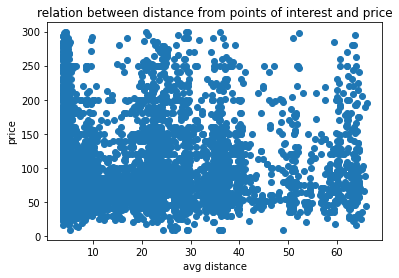

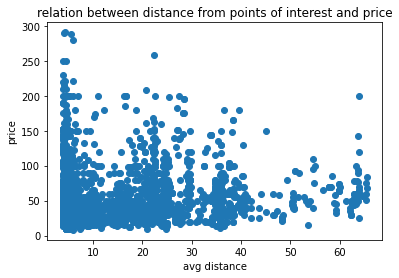

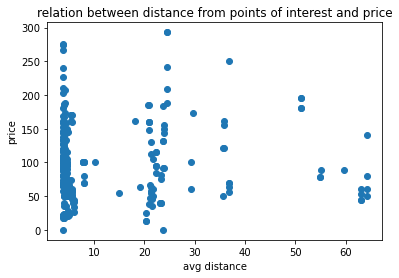

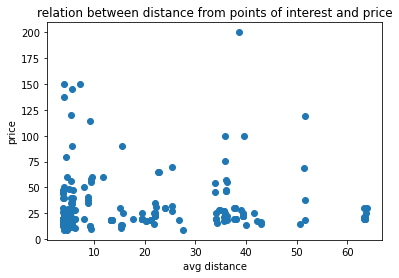

In [366]:
#scatter plots of every sub_dataset representing relation between price and average distance form points of interest
#in some of them we can already see a bit of a correlation between distance from points of interest and price.
plot_gen(df_red_apt)
plot_gen(df_red_rooms)
plot_gen(df_red_hotel)
plot_gen(df_red_shared)

In [367]:
#showing current correlation between average distances and prices, we should choose more accurately the list of points of interest to consider, and then i think 
#he value of these correlation will increase, we should also.. probably more importantly compute regressions coefficients of the aforemetioned variables
#once that is done we can proceede to strip the component of house price that is given by the distance from points of interest and assume the remaining part 
#is given by the distance from metro stations.
correlations={'correlation for apt' : df_red_apt['price'].corr(df_red_apt['avg interest points-house distance']),
             'correlation for rooms' : df_red_rooms['price'].corr(df_red_rooms['avg interest points-house distance']),
             'correlation for hotel' : df_red_hotel['price'].corr(df_red_hotel['avg interest points-house distance']),
             'correlation for shared rooms' : df_red_shared['price'].corr(df_red_shared['avg interest points-house distance'])}

correlations

{'correlation for apt': 0.1341557875349166,
 'correlation for rooms': 0.1567827336064047,
 'correlation for hotel': 0.08347966803227397,
 'correlation for shared rooms': 0.11443475551059397}

In [368]:
df_red_rooms['price'].corr(df_red_rooms['avg interest points-house distance'])

0.1567827336064047

In [315]:
df


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,avg interest points-house distance
2206,6436526,Viewpoint Apartment,5473143,Ana Catarina,Lisboa,Arroios,38.72881,-9.13425,Entire home/apt,45,2,281,2020-03-18,3.55,2,0,0,12686/AL,3.836650
15346,44274384,"Caravana em Pinhal de Sintra a 2,4km da Praia",83275107,Joana,Sintra,Colares,38.81607,-9.45107,Private room,17,1,9,2021-10-31,0.55,2,343,8,Exempt,4.719931
17438,51296603,GuestReady - Bright and Cozy 3BDR Apartment in...,415405043,Anne,Lisboa,Arroios,38.73635,-9.13173,Entire home/apt,118,2,0,NaN,NaN,1,131,0,87324/AL,4.694000
14228,40862676,Reis Leon III @ Cozy apartment with balcony,59156390,Maria,Lisboa,Arroios,38.72369,-9.13595,Entire home/apt,121,2,30,2021-12-07,1.27,17,127,23,100496,4.519445
14941,43213773,studio das portelinhas,239143148,Sabra,Torres Vedras,Ventosa,39.05683,-9.35084,Private room,25,1,20,2021-09-29,1.05,2,223,15,91538,3.842832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12709,35908765,On The Road To Happiness,129128970,Ray,Lisboa,Parque das Naes,38.76507,-9.09617,Entire home/apt,250,2,8,2019-10-05,0.27,1,83,0,Exempt,4.353369
2035,5978897,O retiro da Assafora,28122188,Joao Miguel,Sintra,So Joo das Lampas e Terrugem,38.90760,-9.40804,Entire home/apt,45,2,46,2021-11-13,0.60,1,362,14,10039/AL,4.492455
15120,43777898,Casa de campo - paisagens deslumbrantes e cavalos,340549710,Maria Antonia,Sobral De Monte Agrao,Santo Quintino,38.98800,-9.10905,Entire home/apt,70,1,1,2020-07-17,0.06,2,358,0,104787/AL,5.478441
5044,16035965,Lisbon to business and study,104341643,Marcelo,Loures,"Santa Iria de Azoia, So Joo da Talha e Bobadela",38.80583,-9.09744,Private room,40,10,0,NaN,NaN,1,363,0,NaN,4.459749
